# Injecting signals into TESS light curves.

In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import eleanor
from tqdm import tnrange, trange
from tess_rotation import *

from scipy.interpolate import RectBivariateSpline

In [9]:
# This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

In [10]:
prf = getPrfAtColRowFits(939.361, 1095.571, 1, 4, 1, path)  # col, row, ccd, camera, sector

In [16]:
postflux = fits.open("/Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/" \
                     "hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits")

In [52]:
postcard = postflux[2].data + 0.0
time = postflux[1].data['tstart']
print(np.shape(postcard), np.shape(time))

(1282, 104, 148) (1282,)


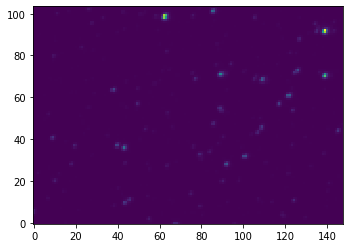

In [53]:
plt.imshow(postcard[0, :, :], origin='lower')

In [54]:
offset_y_1 = 0.5  # this should really be an array that tracks the row and column motions 
offset_x_1 = 0.7  # of the centroid of a star. You can calculate those yourself by taking a bright isolated star
                  # and calculating the center of mass at each cadence and dropping that in, or running eleanor and
                  # taking data.x_com (I think) would get you the same thing and you can drop in those offsets.
print(np.shape(move_prf(prf, offset_x_1, offset_y_1)))

(13, 13)


In [59]:
signal_1 = 300 + 56.0 * np.sin(time*2*np.pi/4.8)  # simple sine wave, you can change it to something more realistic
signal_2 = 10000 * np.ones_like(time)

postcard2 = postcard*1
postcard3 = postcard*1
postcard2[:, 63:76, 33:46] += signal_2[:, None, None]
postcard3[:, 63:76, 33:46] += signal_2[:, None, None] * move_prf(prf, offset_x_1, offset_y_1)[None, :, :]

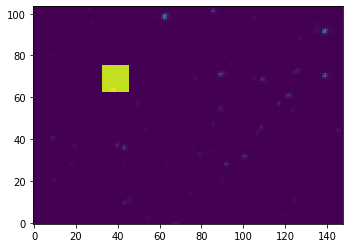

In [60]:
plt.imshow(postcard2[0, :, :], origin='lower')

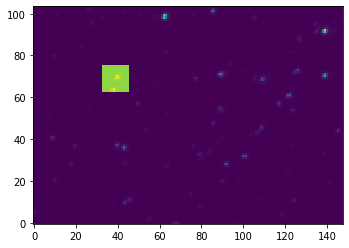

In [61]:
plt.imshow(postcard3[0, :, :], origin='lower')

In [ ]:
# postflux[2].data = postcard + 0.0
# postflux.close()

# Code for downloading eleanor light curves and postage stamps.

In [28]:
import eleanor
star = eleanor.multi_sectors(tic=150428135, sectors=[1, 3])

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  3...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  3 now available.


In [29]:
print(star[0])
print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star[0].tic, star[0].gaia, star[0].tess_mag, star[0].coords[0], star[0].coords[1]))

data = eleanor.TargetData(star[0], height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

Found TIC 150428135 (Gaia 5284517766615492736), with TESS magnitude 10.9102, RA 97.0967865903209, and Dec -65.5793115481931


Set DATE-BEG to '2018-07-25T19:30:10.121' from MJD-BEG'. [astropy.wcs.wcs]
100%|██████████| 1282/1282 [00:11<00:00, 111.72it/s]


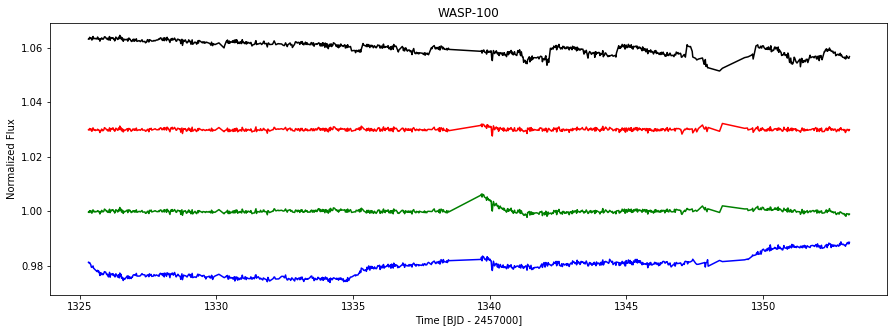

In [30]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('WASP-100');